# 跨品种交易

## 摘要

## 理论模型

如果简单的把国债期货的价格对应于相应期限的国债的价格, 那么不同期限国债期货的价格走势关系就同收益率曲线的形状(平坦或者陡峭)相关.


**曲线交易**

利用收益率曲线进行交易.

**平坦化策略**

预期收益率曲线走势会平坦化, 做空一定数量的短期国债期货, 做多一定数量的长期国债期货.

**陡峭化策略**

预期收益率曲线走势会陡峭化, 做多一定数量的短期国债期货, 做空一定数量的长期国债期货.

由于短期国债与长期国债的久期不同, 收益率变动一个基点时两者价格的变动幅度不同, 跨品种交易建仓的基本原则是构建交易的合约比例能够免疫收益率曲线的平行移动, 使得交易的盈利或亏损只与收益率曲线的斜率变动有关. 实际应用中, 可以考虑使用各自 CTD 券剩余期限的期限利差水平来把握国债期货跨品种价差变化. 另外, 一个经验法则是国债期货合约的久期等于 CTD 券的久期. 简单处理, 可以将建仓比例设置为 CTD 券的久期之比的倒数.


## 实证分析

下面主要以 5, 10 年期国债期货为例进行相关的实证分析.

In [1]:
# coding=utf-8
import time
import sys
import os
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
#%matplotlib notebook
import matplotlib.dates as mdate
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

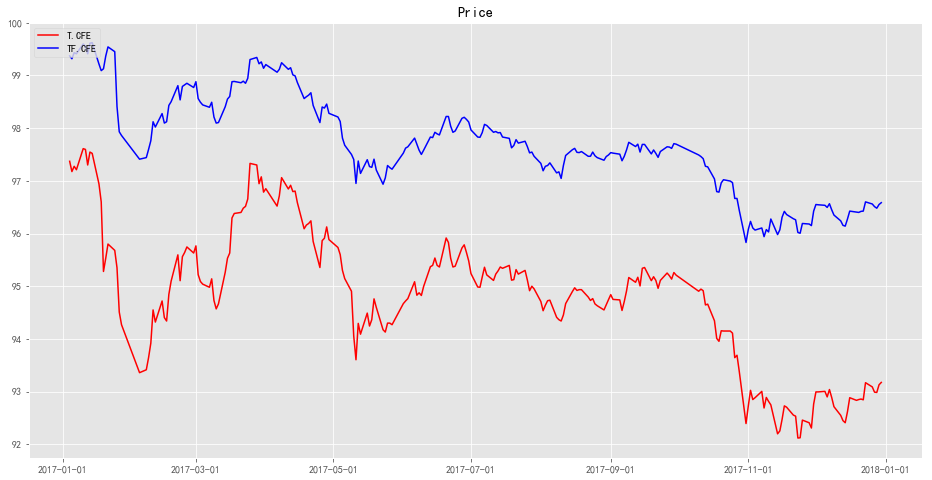

In [2]:
# --------参数设置---------
StartDT = dt.datetime(2017,1,1)
EndDT = dt.datetime(2017,12,31,23,59,59,999999)
LID = "T.CFE"# 长期国债期货合约 ID
SID = "TF.CFE"# 短期国债期货合约 ID

# --------准备数据--------
WDB.connect()
FT = WDB.getTable("中国国债期货交易日行情")
DTs = FT.getDateTime(start_dt=StartDT, end_dt=EndDT)
Price = FT.readData(factor_names=["结算价(元)"], ids=[LID, SID], dts=DTs).iloc[0]
WDB.disconnect()

# Price = np.log(Price)# 取对数价格

# 绘制价格图像
Fig, Axes = plt.subplots(1, 1, figsize=(16, 8))
Axes.xaxis_date()
Axes.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
Axes.plot(Price.index, Price.values[:, 0], color='r', label=Price.columns[0])
Axes.plot(Price.index, Price.values[:, 1], color='b', label=Price.columns[1])
Axes.legend(loc='upper left')
Axes.set_title("Price");

下面我们提取 CTD 券的修正久期, 剩余期限, 到期收益率(%)

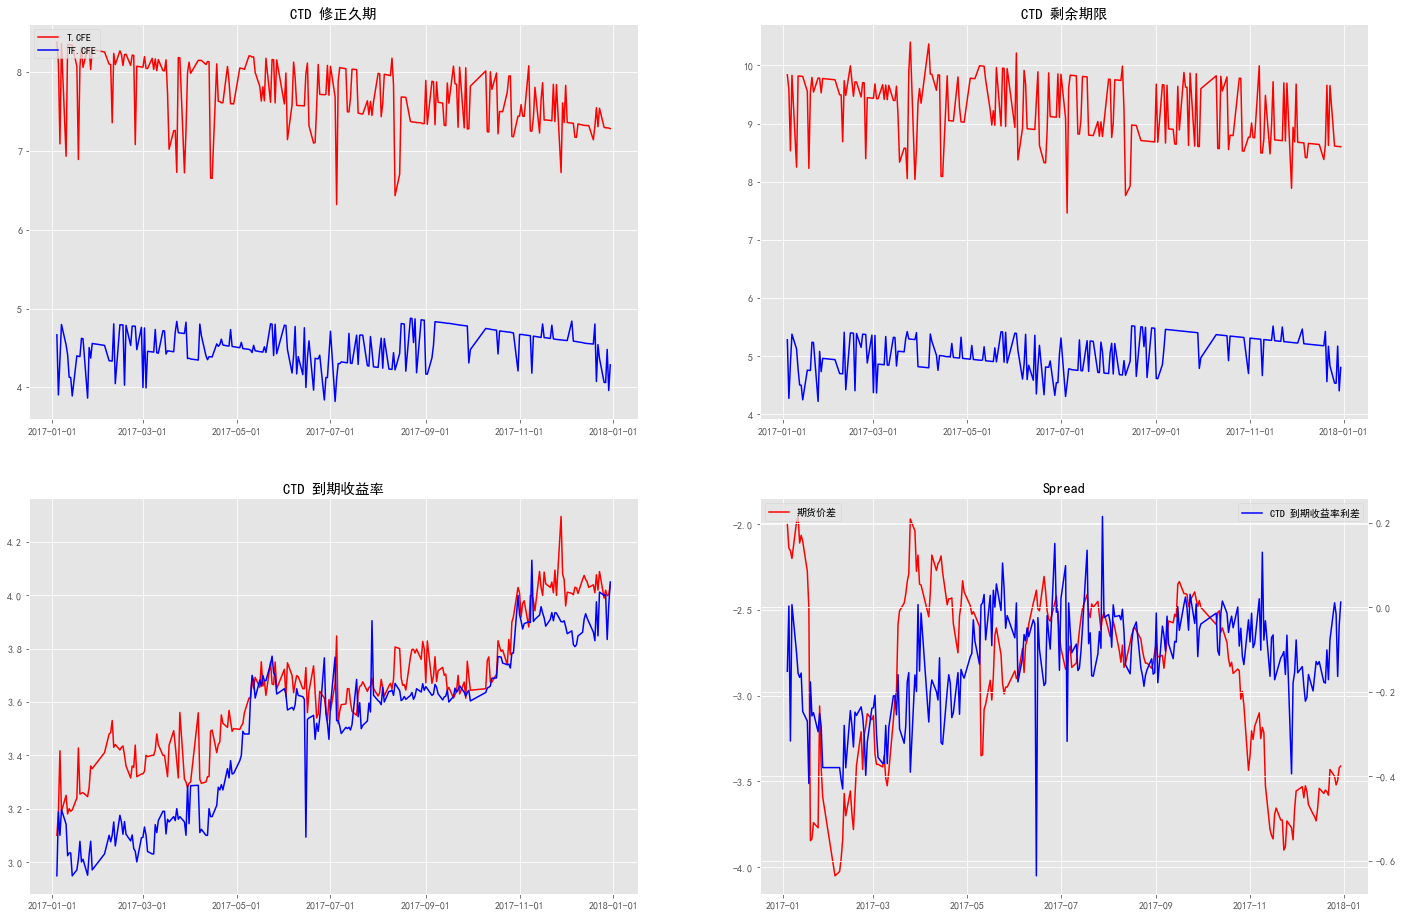

In [3]:
# 提取CTD券, 修正久期, 剩余期限, 到期收益率(%)
WDB.connect()
FutureIDMap = WDB.getTable("中国期货连续(主力)合约和月合约映射表").readData(factor_names=["映射月合约Wind代码"], ids=[LID, SID], dts=DTs).iloc[0,:,:]
FT = WDB.getTable("中国国债期货最便宜可交割券")
CTD, Duration, Yield, ResidualMaturity = pd.DataFrame(index=DTs, columns=Price.columns, dtype="O"), pd.DataFrame(index=DTs, columns=Price.columns), pd.DataFrame(index=DTs, columns=Price.columns), pd.DataFrame(index=DTs, columns=Price.columns)
for j, jFutureID in enumerate(Price.columns):
    jAllFutureIDs = sorted(FutureIDMap[jFutureID].unique())
    for i, iID in enumerate(jAllFutureIDs):
        iDTs = FutureIDMap[FutureIDMap[jFutureID]==iID].index.tolist()
        iCTD = FT.readData(factor_names=["CTD证券Wind代码"], dts=iDTs, ids=[iID]).iloc[0, :, 0]
        CTD.loc[iDTs, jFutureID] = iCTD
        iCTDIDs = iCTD.unique().tolist()
        iBondInfo = WDB.getTable("中国债券衍生指标").readData(factor_names=["修正久期", "剩余期限(年)", "到期收益率(%)"], ids=iCTDIDs, dts=iDTs)
        Duration.loc[iDTs, jFutureID] = np.diag(iBondInfo["修正久期"].loc[:, iCTD.values].values)
        Yield.loc[iDTs, jFutureID] = np.diag(iBondInfo["到期收益率(%)"].loc[:, iCTD.values].values)
        ResidualMaturity.loc[iDTs, jFutureID] = np.diag(iBondInfo["剩余期限(年)"].loc[:, iCTD.values].values)
WDB.disconnect()
Spread = Price.iloc[:, 0] - Price.iloc[:, 1]

# 绘制图像
Fig, Axes = plt.subplots(2, 2, figsize=(24, 16))
iAxes = Axes[0, 0]
iAxes.xaxis_date()
iAxes.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
iAxes.plot(Duration.index, Duration.values[:, 0], color='r', label=Duration.columns[0])
iAxes.plot(Duration.index, Duration.values[:, 1], color='b', label=Duration.columns[1])
iAxes.legend(loc='best')
iAxes.set_title("CTD 修正久期")
iAxes = Axes[0, 1]
iAxes.xaxis_date()
iAxes.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
iAxes.plot(ResidualMaturity.index, ResidualMaturity.values[:, 0], color='r', label=ResidualMaturity.columns[0])
iAxes.plot(ResidualMaturity.index, ResidualMaturity.values[:, 1], color='b', label=ResidualMaturity.columns[1])
iAxes.legend(loc='best')
iAxes.set_title("CTD 剩余期限")
iAxes = Axes[1, 0]
iAxes.xaxis_date()
iAxes.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
iAxes.plot(Yield.index, Yield.values[:, 0], color='r', label=Yield.columns[0])
iAxes.plot(Yield.index, Yield.values[:, 1], color='b', label=Yield.columns[1])
iAxes.legend(loc='best')
iAxes.set_title("CTD 到期收益率")
iAxes = Axes[1, 1]
iAxes.xaxis_date()
iAxes.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
iAxes.plot(Spread.index, Spread.values, color='r', label="期货价差")
RAxis = iAxes.twinx()
RAxis.plot(Yield.index, np.diff(Yield.values, axis=1)[:, 0], color='b', label="CTD 到期收益率利差")
iAxes.legend(loc='upper left')
RAxis.legend(loc='upper right')
iAxes.set_title("Spread");